# Graph Dataset Loading and Batching
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path

import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 14 # use 14 for presentation

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


**Add TENSION(edge) and PRESSURE(cell) attr**

$$T_{edge:(i,j)} = \Lambda_{ij}(t)+\sum_{k\in\{cells\ for\ (i,j)\}}K_p^{(k)}(p^{(k)}-p_0^{(k)})$$
$$\pi_{cell:k} = -2K_a^{(k)}(a^{(k)}-a_0^{(k)})$$

## Working with PyTorch Geometric

`torch_geometric.data.Data` attributes:
- `.x` : node features `[num_nodes, num_node_features]`
- `.edge_index` : edges as \[source, target\] node index pairs (COO format) with shape `[2, num_edges]` and `torch.long` type (int).
- `.edge_attr`: edge features with shape `[num_edges, num_edge_features]`
- `.y` : target, arbitrary shape, if node-level target then `[num_nodes, *]`, or graph-level target `[1, *]`
- `.pos`: node positions `[num_nodes, num_dims]`.
- can add additional attributes, e.g. "cells"

- **Node features** : velocities from previous frames (~ 5 frames--> Alvaro Sanchez-Gonzalez, *et al.* 2020 \[ASG2020\])
- **Edge features** : can use edge directions (optional, might help to speed up training)
- **Current position** : technically a node feature, and needs to be normalized but not processed by the network.
- Positions (Cartesian) to polar edge attributes: `transforms.Polar` \[[link](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.Polar)\], I can also implement or use the `transforms.Cartesian` which computes direction vectors (position pairs -to- normalized direction vectors).
- need transform for velocity noise (use src from example transforms above and ASG2020 paper)
- Trail movie: max edge length ~ 3.25 a.u.

In [4]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.transforms as T

In [38]:
from simgnn.datasets import VertexDynamics, CellData

- `simgnn.datasets.VertexDynamics` (child of `torch_geometric.data.Dataset`)

In [39]:
vtxdata = VertexDynamics('../../../dataDIR/simgnn_data')
vtxdata

Processing...
Done!


VertexDynamics(95)

In [40]:
data=vtxdata[0]

In [41]:
data

CellData(cell2node_index=[2, 600], cell_pressures=[100], edge_index=[2, 678], node2cell_index=[2, 600], pos=[240, 2], x=[240, 5, 2], y=[240, 2])

In [42]:
data.num_cells

100

In [11]:
torch.sum(torch.abs(vtxdata[1].x[:,-1,:]-data.y))

tensor(0.)

In [10]:
# data = vtxdata[0]
# print(data)
# plt.figure(figsize=[10,10])
# plt.title('Monolayer Graph with Cell-to-Nodes Edges')
# nx.draw(to_networkx(data), pos=dict(enumerate(data.pos.numpy())), node_size=30)
# for ci in range(data.num_cells):
#     c_vxpos = data.pos[data.node2cell_index[0][data.node2cell_index[1]==ci]]
#     cpos = c_vxpos.mean(dim=0)
#     for vi in c_vxpos:
#         plt.plot([vi[0],cpos[0]],[vi[1],cpos[1]],lw=3,alpha=.5)
#     plt.plot(cpos[0],cpos[1],'bo',ms=10,alpha=.5)
# # plt.savefig('cell2node.png',dpi=100)

In [78]:
loader = DataLoader([vtxdata[0], vtxdata[25]], batch_size=2)
batch = next(iter(loader))
print(batch)
# nx.draw(to_networkx(batch, to_undirected=True),pos=dict(enumerate(batch.pos.numpy())), node_size=60)

Batch(batch=[480], cell2node_index=[2, 1200], cell_pressures=[200], edge_index=[2, 1356], node2cell_index=[2, 1200], pos=[480, 2], x=[480, 5, 2], y=[480, 2])


In [79]:
batch.cell2node_index[:,batch.cell2node_index[0]==199]

tensor([[199, 199, 199, 199, 199, 199],
        [478, 479, 472, 470, 471, 473]])

In [80]:
d2,d1 = batch.to_data_list()

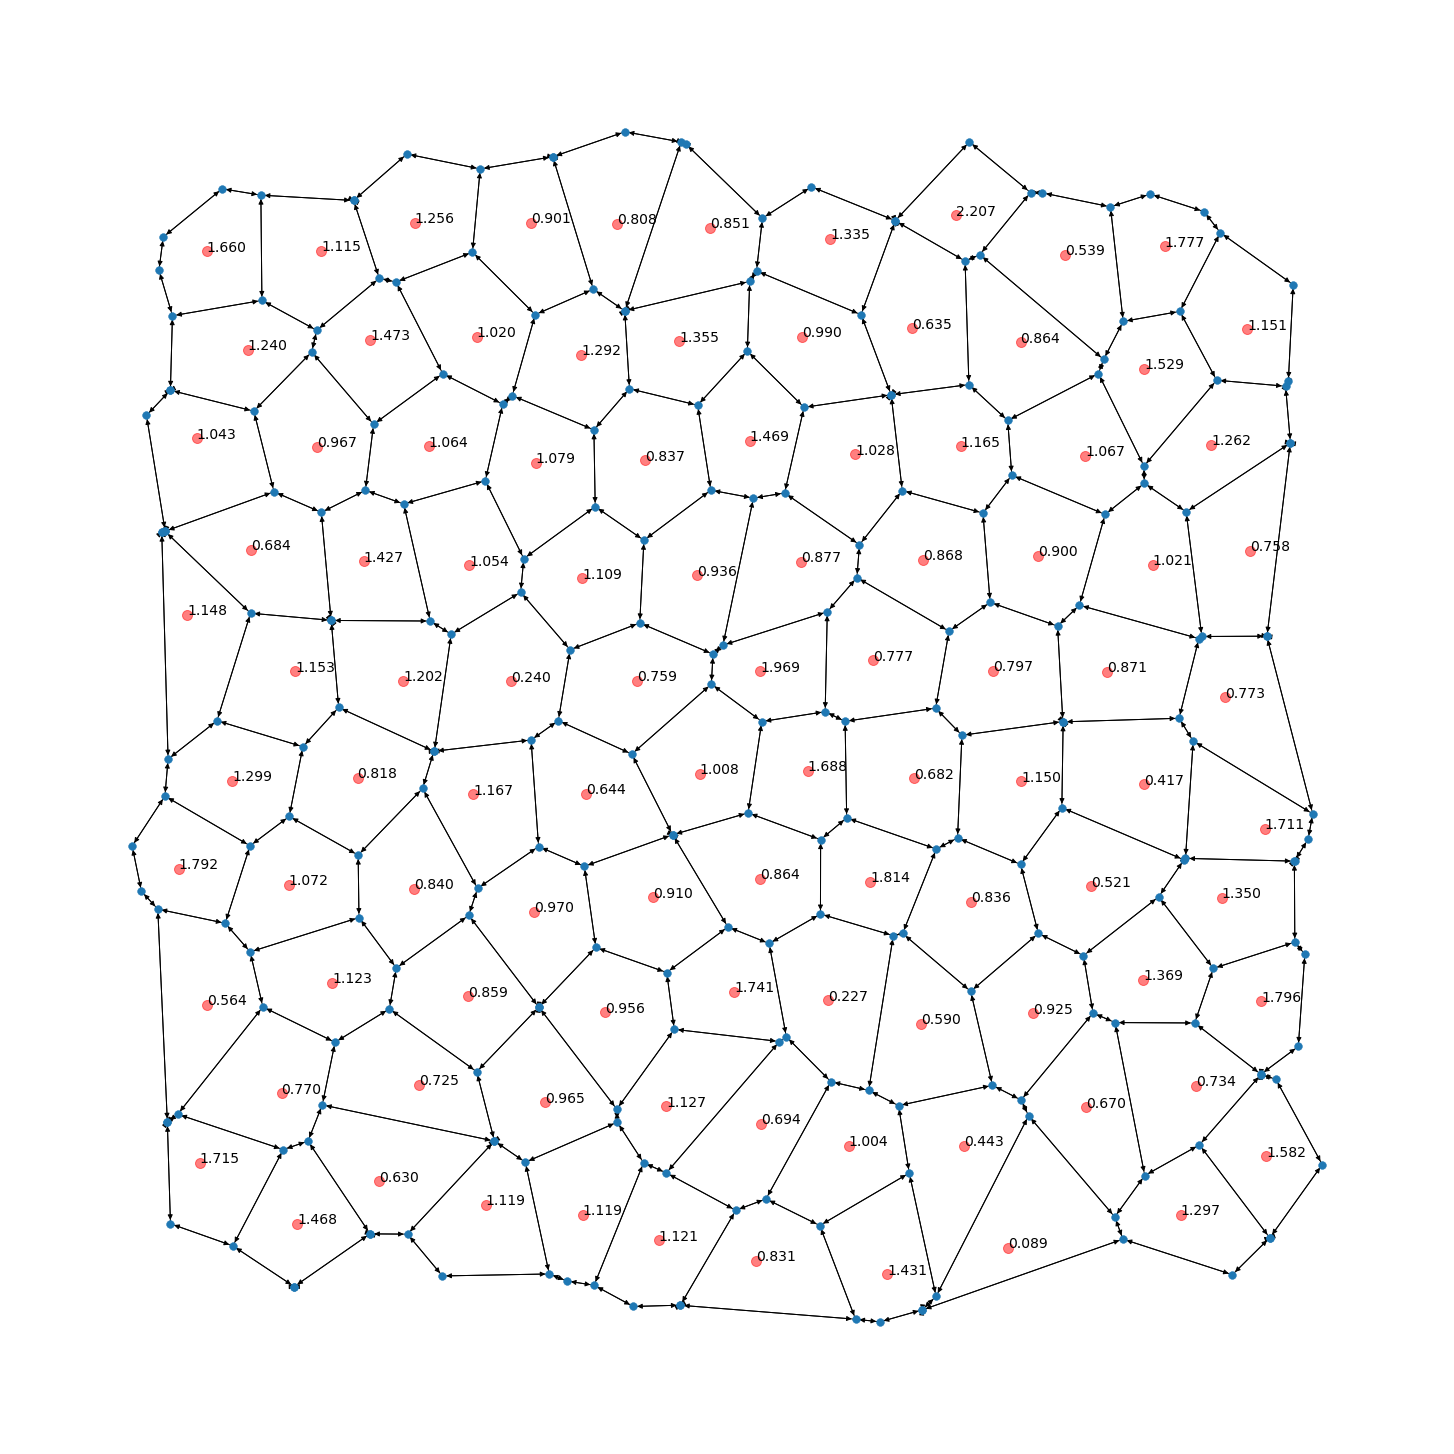

In [84]:
cell_pos = np.stack([d1.pos[d1.cell2node_index[1,d1.cell2node_index[0]==c]].mean(dim=0).numpy() for c in range(d1.num_cells)])
plt.figure(figsize=[20,20])
nx.draw(to_networkx(d1),pos=dict(enumerate(d1.pos.numpy())), node_size=60)
plt.plot(cell_pos[:,0],cell_pos[:,1],'ro',ms=10, alpha=.5)
for c, c_pos in enumerate(cell_pos):
    plt.text(c_pos[0],c_pos[1], f'{d1.cell_pressures[c]:.3f}') 

In [21]:
# t=5
# Dt = 1
# # plt.figure(figsize=[25,25])
# nx.draw(to_networkx(vtxdata[t], to_undirected=True),pos=dict(enumerate(vtxdata[t].pos.numpy())), node_size=60)
# nx.draw(to_networkx(vtxdata[t+Dt], to_undirected=True),pos=dict(enumerate(vtxdata[t+Dt].pos.numpy())),
#         node_size=20,width=4,
#         node_color='#FF00FF',edge_color='#51C5FF',alpha=.5)
# plt.quiver(vtxdata[t].pos.numpy()[:,0], vtxdata[t].pos.numpy()[:,1],
#            vtxdata[t].y.numpy()[:,0],vtxdata[t].y.numpy()[:,1],
#            units='xy',angles='xy',scale=.25,color='r')

In [24]:
# Compare computed and original *edge lengths*
# dist_fn = T.Distance(norm=False)
# compute cartesian distances
# dist_fn(data);

# Working with the Raw data (for Debugging Dataset)

## Set Raw Dataset location

In [6]:
data_root = '../../../dataDIR/simgnn_data/raw'# location of all datasets
raw_path = path.join(data_root,'17Nov2020')

In [7]:
!ls $raw_path

graph_dict.pkl	simul_Ka.npy	     simul_Length.npy	  simul_t.npy
simul_A0.npy	simul_Kp.npy	     simul_P0.npy	  simul_vtxpos.npy
simul_Area.npy	simul_Lambda_ij.npy  simul_Perimeter.npy  t_Energy_maxSpeed.npy


## Loading and Working with Dataset(s)

Representation of cells in the monolayer graph:
- dict of lists with cell numbers $0, 1, \dots N$ as keys, and edges (values).
- edge ind-s **start from 1** in the cells (values), don't forget to **convert** when indexing edges tensor (e.g. `edge_ID=np.abs(ID)-1`). Negative indices indicate reversed order for vertices (cell is defined as a closed region formed by edges connected *end-to-end*). Use `np.sign(cells[c])` to find reversed edges for cell `c`.
    - e.g. get edges of cell `c` : `np.abs(mg_dict['cells'][c])-1` (`mg_dict` is monolayer graph dict loaded with `datautils.load_graph`)

In [19]:
# load dict of monolayer graph
mg_dict = load_graph(path.join(raw_path,'graph_dict.pkl'))

# Load vertex positions from simulation results: Frames x Vertices x Positions
vx_pos = load_array(path.join(raw_path,'simul_vtxpos.npy')) # T x N x 2
vx_vel = np.diff(vx_pos,n=1,axis=0) # T-1 x N x 2

# init-l vertex positions (1st frame)
vx0 = vx_pos[0]

# convert edges list to tensor
edges = torch.tensor(mg_dict['edges'],dtype=torch.long)

In [20]:
type(edges)

torch.Tensor

In [104]:
print('{}\n{}\n{}\n'.format(Area.shape,
                            A0.shape,
                            Ka.shape))

(101, 100)
(101,)
(101,)



In [88]:
Area = load_array(path.join(raw_path, 'simul_Area.npy')) # cell areas Frames x Cells
A0 = load_array(path.join(raw_path, 'simul_A0.npy')) # equilibrium areas Frames x Cells or (Frames,)
Ka = load_array(path.join(raw_path, 'simul_Ka.npy')) # area "spring constants" Frames x Cells or (Frames,)
cell_pressures = -2*Ka.reshape(Area.shape[0],-1)*(Area.reshape(Area.shape[0],-1) - A0.reshape(Area.shape[0],-1)) # Frames x Cells

#####
edge_lengths = load_array(path.join(raw_path, 'simul_Length.npy'))
Lambda_ij = load_array(path.join(raw_path,'simul_Lambda_ij.npy'))
# assert Lambda_ij.shape[1]!=edges.shape[0]

Perims = load_array(path.join(raw_path, 'simul_Perimeter.npy'))
P0 = load_array(path.join(raw_path, 'simul_P0.npy'))
Kp = load_array(path.join(raw_path, 'simul_Kp.npy'))
KpxPerim_minus_P0 = Kp.reshape(Perims.shape[0],-1)*(Perims.squeeze() - P0.reshape(Perims.shape[0],-1) )

# dict of cells sharing same edge
edge_cells={ei:[] for ei in range(edge_lengths.shape[1])}
for ci in mg_dict['cells']:
    for ei in np.abs(mg_dict['cells'][ci])-1:
        edge_cells[ei].append(ci)

sum_KpxPerim_minus_P0 = np.concatenate([KpxPerim_minus_P0[:, edge_cells[ei]].sum(axis=1, keepdims=True) 
                                        for ei in edge_cells], axis=1)

In [24]:
# c=5
# plt.plot(vx0[:,0],vx0[:,1],'ro',ms=10,alpha=.3)
# for edir, e in zip(mg_dict["cells"][c],edges[np.abs(mg_dict["cells"][c])-1]):
#     plt.plot(vx0[e,0],vx0[e,1])
# es=edges[np.abs(mg_dict["cells"][1])-1,0]
# plt.plot(vx0[es,0],vx0[es,1],'bo')

In [90]:
sum_KpxPerim_minus_P0.shape

(101, 339)

In [94]:
# (Lambda_ij-sum_KpxPerim_minus_P0)

### Visualising Var-s and Intermediate Results

In [8]:
# t = 13
# plt.quiver(vx_pos[t,:,0],vx_pos[t,:,1], vx_vel[t,:,0], vx_vel[t,:,1],units='xy',angles='xy',scale=.1)
# plt.plot(vx_pos[t,:,0],vx_pos[t,:,1],'ro',alpha=.5)
# plt.plot(vx_pos[t+1,:,0],vx_pos[t+1,:,1],'bo',alpha=.3)

In [10]:
# edge_lengths.max()
# plt.hist(Perims.ravel(),bins=100);

In [11]:
# plt.hist(Area.ravel(),bins=100);

In [12]:
# plt.hist((edge_lengths.ravel()), bins=50, density=True);
# plt.xlabel('Edge Lengths (a.u.)')
# plt.ylabel('Frequency (normalised)')
# plt.title('10x10 cell monolayer trial with random oscillations\n(17-Nov-2020; 100 sample frames from a movie)')
# plt.savefig('edge_length_17Nov2020.png',dpi=100);

In [13]:
# import networkx as nx
# np.random.seed(42)

# cell_samples = np.random.choice(list(mg_dict['cells'].keys()),10)

# mg_nx = nx.Graph(mg_dict['edges'])
# nx.draw(mg_nx,pos=dict(zip(range(vx0.shape[0]),vx0)),
#         node_size=20,width=4,node_color='#FF00FF',edge_color='#51C5FF')
# for c in cell_samples:
#     c_vxs = vx0[edges[(np.abs(mg_dict['cells'][c])-1)].view(-1,),:]
#     c_loc = c_vxs.mean(axis=0)
#     plt.plot(c_loc[0],c_loc[1],'ro',ms=10)
#     for vx_i in c_vxs:
#         plt.plot([vx_i[0],c_loc[0]], [vx_i[1],c_loc[1]],lw=4)

In [178]:
cell_edge_index[cell_edge_index[:,0]==0,:]

array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5]])

In [182]:
mg_dict['edges'][:6]

[[21, 22], [22, 3], [3, 2], [2, 20], [20, 19], [19, 21]]

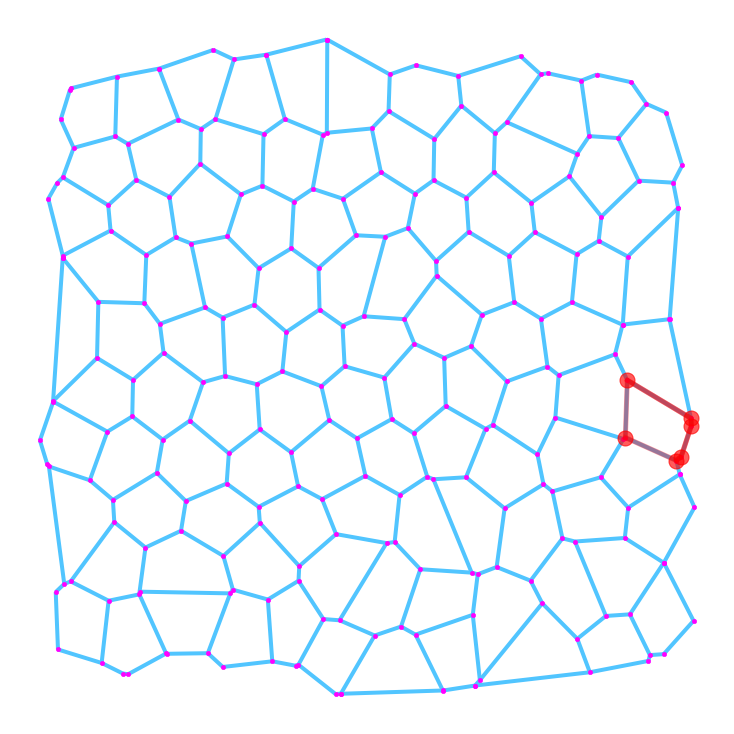

In [183]:
nx.draw(nx.Graph(mg_dict['edges']),
        pos=dict(zip(range(vx0.shape[0]),vx0)),
        node_size=20,width=4,node_color='#FF00FF',edge_color='#51C5FF')
ei = mg_dict['edges'][:6]
plt.plot(vx0[ei,0],vx0[ei,1],'ro-',lw=5,ms=15,alpha=.4)